In [1]:
import numpy as np
import pandas as pd
import pickle
%matplotlib inline

df = pd.read_csv('encode_dataset.csv').head(1000)
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Original_label
0,1255,4,58924,319,443,6,2017-08-18 09:24:00,19121,1,1,...,0.0,0.0,0,0,0,0.0,0,0,44,SMSMALWARE_ZSONE
1,36,4,47222,0,53,17,2017-08-07 12:56:00,61603,1,1,...,0.0,0.0,0,0,0,0.0,0,0,10,BENIGN
2,927,2,49027,162,443,6,2017-07-07 06:09:00,36801,1,1,...,0.0,0.0,0,0,0,0.0,0,0,10,BENIGN
3,461,3,40117,44,443,6,2017-06-17 12:12:00,2945940,3,0,...,0.0,0.0,0,0,0,0.0,0,0,10,BENIGN
4,829,4,51540,116,5001,6,2017-06-30 05:42:00,1000710,2,0,...,0.0,0.0,0,0,0,0.0,0,0,10,BENIGN


In [2]:
df.shape

(1000, 74)

In [3]:
df.isnull().sum()

Flow ID             0
Source IP           0
Source Port         0
Destination IP      0
Destination Port    0
                   ..
Idle Std            0
Idle Max            0
Idle Min            0
Label               0
Original_label      0
Length: 74, dtype: int64

In [4]:
from scikitplot.metrics import plot_precision_recall
import matplotlib.pyplot as plt
   
    
def save_model(model, frs, label, out_dir):
    model.fit(frs, label)
    pickle.dump(model, open(out_dir,'wb'))


def validate(in_dir, X_test, y_test, title):
    model = pickle.load(open(in_dir,'rb'))
    y_probas = model.predict_proba(X_test)
    plot_precision_recall(y_test, y_probas, classes_to_plot=[],
                          title=str('Precision-recall curve micro-averaged over all classes for ' + title))
    plt.show()

Split the dataset to train and test splits in proportion 70 : 30:

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

all_frs = df[df.columns.difference(['Label', 'Original_label', 'Timestamp'])]
X_scaled = preprocessing.scale(all_frs)
label = df.Label

X_train, X_test, y_train, y_test = train_test_split(X_scaled, label, test_size=0.3)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.dummy import DummyClassifier

param_grid = {
    'max_features' : [0.5,0.75,1.0],
    'bootstrap' : [True, False],
    'bootstrap_features' : [True, False]
}
CV_bagging = GridSearchCV(estimator=BaggingClassifier(), param_grid=param_grid, cv=5)
CV_bagging.fit(X_train, y_train)

CV_bagging.best_params_

C:\Users\KANADAM\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0}

Classifiers:

1. baseline classifier - Zero R (DummyClassifier);
2. Random Subspaces - BaggingClassifier(bootstrap = False, bootstrap_features = True);
3. multinomial logistic regression.

In [7]:
models = [(DummyClassifier(strategy="most_frequent"), 'baseline.pkl', 'Zero R'),
          (BaggingClassifier(bootstrap = False, bootstrap_features = True), 'bagging.pkl', 'Bagging classifier'),
          (LogisticRegression(multi_class='multinomial', max_iter=3000), 'log_regression.pkl', 'Logistic Regression')
         ]

Save models:

In [8]:
for clr, out_dir, _ in models:    
    save_model(clr, X_train, y_train, out_dir)

Validate the held-out set:

ValueError: Found input variables with inconsistent numbers of samples: [12600, 13500]

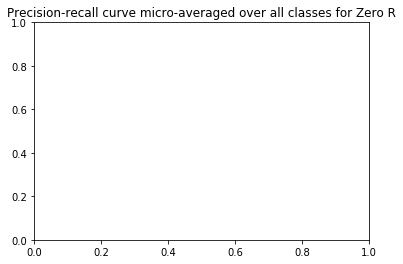

In [9]:
for _, in_dir, title in models:    
    validate(in_dir, X_test, y_test, title)

Train Learning Curve: learning curve calculated from the training dataset that gives an idea of how well the model is learning.

In [ ]:
from scikitplot.estimators import plot_learning_curve

for clr,  out_dir, _ in models:    
    plot_learning_curve(clr, X_train, y_train)


Validation Learning Curve: Learning curve calculated from a hold-out validation dataset that gives an idea of how well the model is generalizing.

In [ ]:
for clr,  out_dir, _ in models:    
    plot_learning_curve(clr, X_test, y_test)